# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
from huggingface_hub import HfApi, HfFolder, Repository
import json 
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# Data Loading

In [2]:
def loading_dataset_train(path1, path2):
    
    high = []
    low = []
    
    for sub_folder in ["high", "low"]:
        sub_path = os.path.join(path1, sub_folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img = Image.open(img_path)
            img = img.resize((1024, 1024))
            img_np = np.array(img)
            if(sub_folder == "high"):
                high.append(img_np)
            else:
                low.append(img_np)
                
    noisy_images_path = []
    gt_images_path = []
    
    instances_path = os.path.join(path2, "Scene_Instances.txt")
    with open(instances_path) as f:
        instances = f.read()
    
    instances = instances.split('\n')
    for f in instances:
        images_path = os.path.join(path2, "Data")
        images_path = os.path.join(images_path, f)

        for g in os.listdir(images_path):
            image_path = os.path.join(images_path, g)

            if 'NOISY' in image_path:
                noisy_images_path.append(image_path)
            else:
                gt_images_path.append(image_path)
                
    for img_path in noisy_images_path:
            img = Image.open(img_path)
            img = img.resize((1024, 1024))
            img_np = np.array(img)
            low.append(img_np)
    for img_path in gt_images_path:
            img = Image.open(img_path)
            img = img.resize((1024, 1024))
            img_np = np.array(img)
            high.append(img_np)
    return low, high

In [3]:
def loading_dataset_val(path1):
    
    high = []
    low = []
    
    for sub_folder in ["high", "low"]:
        sub_path = os.path.join(path1, sub_folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            if(sub_folder == "high"):
                high.append(img_np)
            else:
                low.append(img_np)
                
    return low, high

In [4]:
train_low, train_high = loading_dataset_train("/kaggle/input/lol-dataset/lol_dataset/our485", "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only")

In [5]:
val_low, val_high = loading_dataset_val("/kaggle/input/lol-dataset/lol_dataset/eval15")

# Image Display Fucntions

In [6]:
def dis_img(img1, img2):
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1/255)
    plt.title("Low Quality Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2/255)
    plt.title("High Quality Image")
    plt.axis("off")
    
    plt.show()

In [7]:
def dis_img_test(img1, img2, img3):
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img1/255)
    plt.title("Low Quality Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(img2/255)
    plt.title("High Quality Image(Target)")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(img3/255)
    plt.title("High Quality Image(Predicted)")
    plt.axis("off")
    
    plt.show()

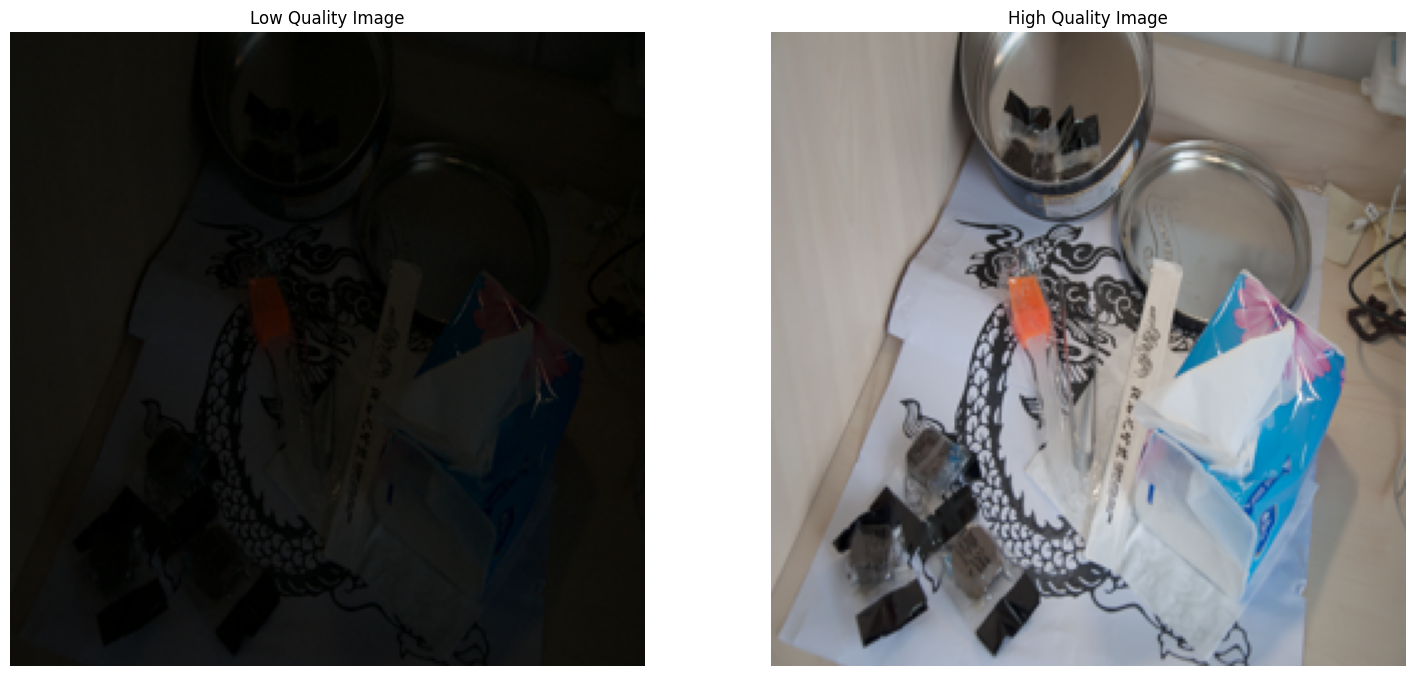

In [8]:
dis_img(train_low[40], train_high[40])

# PSNR Calculation

In [9]:
def calculate_psnr(original_img, denoised_img):
    
    original_img = original_img.astype(np.float64)
    denoised_img = denoised_img.astype(np.float64)
    
    mse = np.mean((original_img - denoised_img) ** 2)
    
    if mse == 0:
        return float('inf')
    
    max_pixel = original_img.max() - original_img.min()
    
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Creating Patches

In [10]:
def create_patches(images, patch_size=(256, 256, 3)):
    combined_patches = []

    for image in images:
        H, W, C = image.shape
        patch_height, patch_width, patch_channels = patch_size

        patches = []
        for i in range(0, H, patch_height):
            for j in range(0, W, patch_width):
                patch = image[i:i + patch_height, j:j + patch_width, :]
                patches.append(patch)

        combined_patches.extend(patches)

    return combined_patches

# Applying transform and loading the dataset into dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        input_image = self.X[idx]
        denoised_image = self.y[idx]
        
        if self.transform:
            input_image = self.transform(input_image)
            denoised_image = self.transform(denoised_image)
        
        return input_image, denoised_image

In [12]:
input_transform = transforms.Compose([transforms.ToTensor()])

In [13]:
train_low_patches = create_patches(train_low)
train_high_patches = create_patches(train_high)

In [14]:
dataset = CustomDataset(train_low_patches, train_high_patches,input_transform)

In [15]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [16]:
val_dataset = CustomDataset(val_low, val_high, input_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [17]:
for batch in dataloader:
    i, j = batch
    print(f"i : {i.shape}, j : {j.shape}")
    break

i : torch.Size([8, 3, 256, 256]), j : torch.Size([8, 3, 256, 256])


# Defining RIDNet architecture

In [18]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.conv1 =nn.Conv2d(in_channels, out_channels//reduction, 1, 1, 0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels//reduction, in_channels, 1, 1, 0)
        self.sigmoid2 = nn.Sigmoid()

    def forward(self, x):
        gap = self.gap(x)
        x_out = self.conv1(gap)
        x_out = self.relu1(x_out)
        x_out = self.conv2(x_out)
        x_out = self.sigmoid2(x_out)
        x_out = x_out * x        
        return x_out

In [19]:
class EAM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, reduciton=4):
        super(EAM, self).__init__()

        self.path1_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
        self.path1_relu1 = nn.ReLU()
        self.path1_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=2, dilation=2)
        self.path1_relu2 = nn.ReLU()

        self.path2_conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=3, dilation=3)
        self.path2_relu1 = nn.ReLU()
        self.path2_conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=4, dilation=4)
        self.path2_relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels*2, out_channels, kernel_size, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu8 = nn.ReLU()

        self.ca = ChannelAttention(in_channels, out_channels, reduction=16)

    def forward(self, x):
        
        x1 = self.path1_conv1(x)
        x1 = self.path1_relu1(x1)        
        x1 = self.path1_conv2(x1)
        x1 = self.path1_relu2(x1)

        x2 = self.path2_conv1(x)
        x2 = self.path2_relu1(x2)
        x2 = self.path2_conv2(x2)
        x2 = self.path2_relu2(x2)

        x3 = torch.cat([x1, x2], dim=1)
        x3 = self.conv3(x3)
        x3 = self.relu3(x3)
        x3 = x3 + x

        x4 = self.conv4(x3)
        x4 = self.relu4(x4)
        x4 = self.conv5(x4)
        x5 = x4 + x3
        x5 = self.relu5(x5)

        x6 = self.conv6(x5)
        x6 = self.relu6(x6)
        x7 = self.conv7(x6)
        x7 = self.relu7(x7)
        x8 = self.conv8(x7)
        x8 = x8 + x5
        x8 = self.relu8(x8)

        x_ca = self.ca(x8)
        
        return x_ca + x

In [20]:
class RIDNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_feautres):
        super(RIDNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, num_feautres, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=False)

        self.eam1 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam2 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam3 = EAM(in_channels=num_feautres, out_channels=num_feautres)
        self.eam4 = EAM(in_channels=num_feautres, out_channels=num_feautres)

        self.last_conv = nn.Conv2d(num_feautres, out_channels, kernel_size=3, stride=1, padding=1, dilation=1)
        
        self.init_weights()

    def forward(self, x):        
        x1 = self.conv1(x) 
        x1 = self.relu1(x1)
        
        x_eam = self.eam1(x1)                
        x_eam = self.eam2(x_eam)
        x_eam = self.eam3(x_eam)
        x_eam = self.eam4(x_eam)
        
        x_lsc = x_eam + x1 
        x_out = self.last_conv(x_lsc) 
        x_out = x_out + x 

        return x_out

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)            
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [21]:
# import torch
# import gc

# def clear_gpu_memory():
#     torch.cuda.empty_cache()
#     gc.collect()
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# #     with torch.no_grad():
# # #         Example of deleting model if you have one
# #         if 'Model' in globals():
# #             del Model
# # #         Delete any other variables on the GPU
# #         if 'variable_name' in globals():
# #             del variable_name

#     torch.cuda.empty_cache()
#     gc.collect()
# clear_gpu_memory()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))


In [22]:
Model = RIDNet(3, 3, 128)

# Moving the model to GPU

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
Model = Model.to(device)

# Loss and Optimizer

In [25]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(Model.parameters(), lr=1e-3)

In [26]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

In [27]:
loss = []

In [28]:
epochs = 100

In [29]:
def validation(Model):
    Model.eval()
    with torch.no_grad():
        val_psnr_t = 0
        val_min_psnr = 50
        val_max_psnr = -50
        val_loss = 0
        for batch in val_loader:
            low_img, high_img = batch
            low_img = low_img.to(device)


            denoished_img = Model(low_img)
            denoished_img = denoished_img.to("cpu")
            val_loss += criterion(denoished_img, high_img).item() 
            denoished_img = denoished_img.squeeze()
            high_img = high_img.squeeze()
            denoished_img = denoished_img.detach().numpy()
            high_img = high_img.numpy()
            denoished_img = np.transpose(denoished_img,(1,2,0))
            high_img = np.transpose(high_img,(1,2,0))
            psnr =  calculate_psnr(denoished_img, high_img)
            
            val_psnr_t += psnr
            if psnr>val_max_psnr :
                val_max_psnr = psnr
            if psnr<val_min_psnr:
                val_min_psnr = psnr

        val_psnr_t /= len(val_loader)
        val_loss /= len(val_loader)
        return val_loss, val_psnr_t

In [30]:
def training(Model):
    Model.eval()
    with torch.no_grad():
        train_psnr_t = 0
        train_min_psnr = 50
        train_max_psnr = -50
        train_loss = 0
        for batch in dataloader:
            low_imgs, high_imgs = batch
            low_imgs = low_imgs.to(device)

            denoished_imgs = Model(low_imgs)
            denoished_imgs = denoished_imgs.to("cpu")
            train_loss += criterion(denoished_imgs, high_imgs).item() 
            batch_psnr_sum = 0
            for i in range(denoished_imgs.shape[0]):
                denoished_img = denoished_imgs[i]
                high_img = high_imgs[i]
                denoished_img = denoished_img.detach().numpy()
                high_img = high_img.numpy()
                denoished_img = np.transpose(denoished_img,(1,2,0))
                high_img = np.transpose(high_img,(1,2,0))
                psnr =  calculate_psnr(denoished_img, high_img)

                batch_psnr_sum += psnr
                if psnr>train_max_psnr :
                    train_max_psnr = psnr
                if psnr<train_min_psnr:
                    train_min_psnr = psnr
            
            train_psnr_t += batch_psnr_sum / denoished_imgs.shape[0]

        train_psnr_t /= len(dataloader)
        train_loss /= len(dataloader)
        return train_loss, train_psnr_t

# Model Training

In [31]:
for epoch in range(epochs):
    loss_e = 0
    for batch in tqdm(dataloader):
        Model.train()
        optimizer.zero_grad()
        
        low_img, high_img = batch
        low_img = low_img.to(device)
        high_img = high_img.to(device)
        
        denoished_img = Model(low_img)
        
        error = criterion(denoished_img, high_img) 
        
        error.backward()
        optimizer.step()
        loss_e += error.item()

    scheduler.step()
    loss_e /= len(dataloader)
    loss.append(loss_e)
    val_loss, val_psnr = validation(Model)
    train_loss, train_psnr = training(Model)
    print(f"{epoch+1} / {epochs} Runnung Training loss : {loss_e}")
    print(f"Training loss : {train_loss:.4f} Training PSNR : {train_psnr:.4f} Validation Loss : {val_loss:.4f} Validation PSNR : {val_psnr:.4f}")

  0%|          | 0/81 [00:00<?, ?it/s]

1 / 100 Runnung Training loss : 0.3742110284022343
Training loss : 0.1724 Training PSNR : 10.7807 Validation Loss : 0.1976 Validation PSNR : 8.9986


  0%|          | 0/81 [00:00<?, ?it/s]

2 / 100 Runnung Training loss : 0.16206998699977074
Training loss : 0.1570 Training PSNR : 12.1497 Validation Loss : 0.1603 Validation PSNR : 11.4588


  0%|          | 0/81 [00:00<?, ?it/s]

3 / 100 Runnung Training loss : 0.1540633010459535
Training loss : 0.1411 Training PSNR : 13.7518 Validation Loss : 0.1446 Validation PSNR : 13.0538


  0%|          | 0/81 [00:00<?, ?it/s]

4 / 100 Runnung Training loss : 0.14424605244471703
Training loss : 0.1436 Training PSNR : 13.6583 Validation Loss : 0.1555 Validation PSNR : 12.3494


  0%|          | 0/81 [00:00<?, ?it/s]

5 / 100 Runnung Training loss : 0.14257239651532821
Training loss : 0.1348 Training PSNR : 14.9961 Validation Loss : 0.1384 Validation PSNR : 14.0657


  0%|          | 0/81 [00:00<?, ?it/s]

6 / 100 Runnung Training loss : 0.13772876882626686
Training loss : 0.1344 Training PSNR : 14.2875 Validation Loss : 0.1563 Validation PSNR : 12.1247


  0%|          | 0/81 [00:00<?, ?it/s]

7 / 100 Runnung Training loss : 0.13541521941438134
Training loss : 0.1377 Training PSNR : 14.1423 Validation Loss : 0.1516 Validation PSNR : 13.4226


  0%|          | 0/81 [00:00<?, ?it/s]

8 / 100 Runnung Training loss : 0.12698400443718758
Training loss : 0.1148 Training PSNR : 17.4945 Validation Loss : 0.1184 Validation PSNR : 16.2432


  0%|          | 0/81 [00:00<?, ?it/s]

9 / 100 Runnung Training loss : 0.11983520123693678
Training loss : 0.1164 Training PSNR : 18.3406 Validation Loss : 0.1150 Validation PSNR : 18.2529


  0%|          | 0/81 [00:00<?, ?it/s]

10 / 100 Runnung Training loss : 0.10925669278259631
Training loss : 0.0971 Training PSNR : 20.6757 Validation Loss : 0.1149 Validation PSNR : 19.5509


  0%|          | 0/81 [00:00<?, ?it/s]

11 / 100 Runnung Training loss : 0.10399588579196989
Training loss : 0.1000 Training PSNR : 19.9737 Validation Loss : 0.1180 Validation PSNR : 17.8016


  0%|          | 0/81 [00:00<?, ?it/s]

12 / 100 Runnung Training loss : 0.09613631748490864
Training loss : 0.0921 Training PSNR : 20.1332 Validation Loss : 0.1110 Validation PSNR : 18.4155


  0%|          | 0/81 [00:00<?, ?it/s]

13 / 100 Runnung Training loss : 0.09367942736472612
Training loss : 0.0905 Training PSNR : 20.9377 Validation Loss : 0.1075 Validation PSNR : 18.7996


  0%|          | 0/81 [00:00<?, ?it/s]

14 / 100 Runnung Training loss : 0.09251000097504368
Training loss : 0.0869 Training PSNR : 21.6494 Validation Loss : 0.1109 Validation PSNR : 19.5019


  0%|          | 0/81 [00:00<?, ?it/s]

15 / 100 Runnung Training loss : 0.09797369313920722
Training loss : 0.0884 Training PSNR : 21.3079 Validation Loss : 0.1034 Validation PSNR : 20.0990


  0%|          | 0/81 [00:00<?, ?it/s]

16 / 100 Runnung Training loss : 0.09020955014375993
Training loss : 0.1006 Training PSNR : 20.6070 Validation Loss : 0.1180 Validation PSNR : 19.0615


  0%|          | 0/81 [00:00<?, ?it/s]

17 / 100 Runnung Training loss : 0.09249981446766559
Training loss : 0.0927 Training PSNR : 21.0696 Validation Loss : 0.1025 Validation PSNR : 19.8974


  0%|          | 0/81 [00:00<?, ?it/s]

18 / 100 Runnung Training loss : 0.0900114490478127
Training loss : 0.0815 Training PSNR : 22.6326 Validation Loss : 0.0996 Validation PSNR : 20.3092


  0%|          | 0/81 [00:00<?, ?it/s]

19 / 100 Runnung Training loss : 0.08907856543858846
Training loss : 0.0961 Training PSNR : 21.3714 Validation Loss : 0.1105 Validation PSNR : 20.2312


  0%|          | 0/81 [00:00<?, ?it/s]

20 / 100 Runnung Training loss : 0.09045069416364034
Training loss : 0.0968 Training PSNR : 21.2366 Validation Loss : 0.1144 Validation PSNR : 19.8032


  0%|          | 0/81 [00:00<?, ?it/s]

21 / 100 Runnung Training loss : 0.08840120450398069
Training loss : 0.0837 Training PSNR : 21.5812 Validation Loss : 0.1012 Validation PSNR : 19.9344


  0%|          | 0/81 [00:00<?, ?it/s]

22 / 100 Runnung Training loss : 0.08625176286807766
Training loss : 0.0958 Training PSNR : 20.6992 Validation Loss : 0.1110 Validation PSNR : 19.0878


  0%|          | 0/81 [00:00<?, ?it/s]

23 / 100 Runnung Training loss : 0.08676304162284475
Training loss : 0.0867 Training PSNR : 21.7274 Validation Loss : 0.1012 Validation PSNR : 20.3768


  0%|          | 0/81 [00:00<?, ?it/s]

24 / 100 Runnung Training loss : 0.08860133454939466
Training loss : 0.0771 Training PSNR : 22.6908 Validation Loss : 0.0978 Validation PSNR : 20.0128


  0%|          | 0/81 [00:00<?, ?it/s]

25 / 100 Runnung Training loss : 0.08520709893401758
Training loss : 0.0811 Training PSNR : 22.3630 Validation Loss : 0.1008 Validation PSNR : 19.8160


  0%|          | 0/81 [00:00<?, ?it/s]

26 / 100 Runnung Training loss : 0.08141324508153362
Training loss : 0.0793 Training PSNR : 23.0612 Validation Loss : 0.0982 Validation PSNR : 20.6585


  0%|          | 0/81 [00:00<?, ?it/s]

27 / 100 Runnung Training loss : 0.08218217084621206
Training loss : 0.1043 Training PSNR : 20.0204 Validation Loss : 0.1319 Validation PSNR : 17.9166


  0%|          | 0/81 [00:00<?, ?it/s]

28 / 100 Runnung Training loss : 0.08675016554785364
Training loss : 0.0772 Training PSNR : 23.2257 Validation Loss : 0.1046 Validation PSNR : 19.6399


  0%|          | 0/81 [00:00<?, ?it/s]

29 / 100 Runnung Training loss : 0.08894359665336432
Training loss : 0.0798 Training PSNR : 22.7897 Validation Loss : 0.0994 Validation PSNR : 20.5219


  0%|          | 0/81 [00:00<?, ?it/s]

30 / 100 Runnung Training loss : 0.08649652396087293
Training loss : 0.0767 Training PSNR : 23.0536 Validation Loss : 0.0943 Validation PSNR : 20.4347


  0%|          | 0/81 [00:00<?, ?it/s]

31 / 100 Runnung Training loss : 0.0799399295154913
Training loss : 0.0869 Training PSNR : 22.3889 Validation Loss : 0.1019 Validation PSNR : 20.0821


  0%|          | 0/81 [00:00<?, ?it/s]

32 / 100 Runnung Training loss : 0.08208534912562665
Training loss : 0.0773 Training PSNR : 23.2552 Validation Loss : 0.0996 Validation PSNR : 20.0699


  0%|          | 0/81 [00:00<?, ?it/s]

33 / 100 Runnung Training loss : 0.0811204075537346
Training loss : 0.0840 Training PSNR : 22.7258 Validation Loss : 0.0977 Validation PSNR : 20.5051


  0%|          | 0/81 [00:00<?, ?it/s]

34 / 100 Runnung Training loss : 0.08154888984597759
Training loss : 0.0740 Training PSNR : 22.9488 Validation Loss : 0.0914 Validation PSNR : 20.7788


  0%|          | 0/81 [00:00<?, ?it/s]

35 / 100 Runnung Training loss : 0.08148961592419648
Training loss : 0.0774 Training PSNR : 22.7537 Validation Loss : 0.0961 Validation PSNR : 19.9006


  0%|          | 0/81 [00:00<?, ?it/s]

36 / 100 Runnung Training loss : 0.07631575394375825
Training loss : 0.0765 Training PSNR : 23.3560 Validation Loss : 0.1005 Validation PSNR : 20.1414


  0%|          | 0/81 [00:00<?, ?it/s]

37 / 100 Runnung Training loss : 0.07909943535923958
Training loss : 0.0762 Training PSNR : 22.5551 Validation Loss : 0.0986 Validation PSNR : 19.9577


  0%|          | 0/81 [00:00<?, ?it/s]

38 / 100 Runnung Training loss : 0.08091646584647673
Training loss : 0.0776 Training PSNR : 22.9282 Validation Loss : 0.1046 Validation PSNR : 19.5287


  0%|          | 0/81 [00:00<?, ?it/s]

39 / 100 Runnung Training loss : 0.08112823300891453
Training loss : 0.0722 Training PSNR : 23.9721 Validation Loss : 0.0953 Validation PSNR : 20.8833


  0%|          | 0/81 [00:00<?, ?it/s]

40 / 100 Runnung Training loss : 0.07977725211300968
Training loss : 0.0811 Training PSNR : 22.3527 Validation Loss : 0.0999 Validation PSNR : 20.2808


  0%|          | 0/81 [00:00<?, ?it/s]

41 / 100 Runnung Training loss : 0.08017032138175434
Training loss : 0.0884 Training PSNR : 22.1354 Validation Loss : 0.1047 Validation PSNR : 20.1925


  0%|          | 0/81 [00:00<?, ?it/s]

42 / 100 Runnung Training loss : 0.07941095425206939
Training loss : 0.0984 Training PSNR : 21.1999 Validation Loss : 0.1172 Validation PSNR : 19.3372


  0%|          | 0/81 [00:00<?, ?it/s]

43 / 100 Runnung Training loss : 0.07795719701198885
Training loss : 0.0717 Training PSNR : 23.5469 Validation Loss : 0.0916 Validation PSNR : 20.7714


  0%|          | 0/81 [00:00<?, ?it/s]

44 / 100 Runnung Training loss : 0.07606133533480727
Training loss : 0.0794 Training PSNR : 22.6475 Validation Loss : 0.0999 Validation PSNR : 20.2452


  0%|          | 0/81 [00:00<?, ?it/s]

45 / 100 Runnung Training loss : 0.07718478580131943
Training loss : 0.0835 Training PSNR : 22.4305 Validation Loss : 0.0986 Validation PSNR : 20.6952


  0%|          | 0/81 [00:00<?, ?it/s]

46 / 100 Runnung Training loss : 0.07722551407821385
Training loss : 0.0732 Training PSNR : 23.6223 Validation Loss : 0.0983 Validation PSNR : 20.1141


  0%|          | 0/81 [00:00<?, ?it/s]

47 / 100 Runnung Training loss : 0.07526589060823123
Training loss : 0.0895 Training PSNR : 21.8209 Validation Loss : 0.1049 Validation PSNR : 19.7933


  0%|          | 0/81 [00:00<?, ?it/s]

48 / 100 Runnung Training loss : 0.08026289640937323
Training loss : 0.0722 Training PSNR : 23.7703 Validation Loss : 0.0926 Validation PSNR : 20.6617


  0%|          | 0/81 [00:00<?, ?it/s]

49 / 100 Runnung Training loss : 0.07591442446465846
Training loss : 0.0786 Training PSNR : 23.2061 Validation Loss : 0.0944 Validation PSNR : 20.8703


  0%|          | 0/81 [00:00<?, ?it/s]

50 / 100 Runnung Training loss : 0.07483053062525061
Training loss : 0.0724 Training PSNR : 24.1152 Validation Loss : 0.0910 Validation PSNR : 21.6027


  0%|          | 0/81 [00:00<?, ?it/s]

51 / 100 Runnung Training loss : 0.07403706441874858
Training loss : 0.0698 Training PSNR : 23.7815 Validation Loss : 0.0897 Validation PSNR : 21.1888


  0%|          | 0/81 [00:00<?, ?it/s]

52 / 100 Runnung Training loss : 0.07143503114765073
Training loss : 0.0682 Training PSNR : 24.0902 Validation Loss : 0.0887 Validation PSNR : 20.8736


  0%|          | 0/81 [00:00<?, ?it/s]

53 / 100 Runnung Training loss : 0.0754024459991926
Training loss : 0.0818 Training PSNR : 23.1622 Validation Loss : 0.1058 Validation PSNR : 19.6889


  0%|          | 0/81 [00:00<?, ?it/s]

54 / 100 Runnung Training loss : 0.07529547828951
Training loss : 0.0694 Training PSNR : 24.4421 Validation Loss : 0.0910 Validation PSNR : 21.1818


  0%|          | 0/81 [00:00<?, ?it/s]

55 / 100 Runnung Training loss : 0.07230379827964453
Training loss : 0.0762 Training PSNR : 22.7820 Validation Loss : 0.1011 Validation PSNR : 19.8490


  0%|          | 0/81 [00:00<?, ?it/s]

56 / 100 Runnung Training loss : 0.07154450413805467
Training loss : 0.0725 Training PSNR : 23.9567 Validation Loss : 0.0968 Validation PSNR : 20.5550


  0%|          | 0/81 [00:00<?, ?it/s]

57 / 100 Runnung Training loss : 0.07654074561080815
Training loss : 0.0726 Training PSNR : 24.0151 Validation Loss : 0.0962 Validation PSNR : 20.4218


  0%|          | 0/81 [00:00<?, ?it/s]

58 / 100 Runnung Training loss : 0.07210520956159373
Training loss : 0.0774 Training PSNR : 23.5699 Validation Loss : 0.0922 Validation PSNR : 21.3992


  0%|          | 0/81 [00:00<?, ?it/s]

59 / 100 Runnung Training loss : 0.07209975076954306
Training loss : 0.0699 Training PSNR : 23.9949 Validation Loss : 0.0910 Validation PSNR : 20.7842


  0%|          | 0/81 [00:00<?, ?it/s]

60 / 100 Runnung Training loss : 0.07335885604958475
Training loss : 0.0678 Training PSNR : 24.7752 Validation Loss : 0.0929 Validation PSNR : 20.9553


  0%|          | 0/81 [00:00<?, ?it/s]

61 / 100 Runnung Training loss : 0.06988961139210949
Training loss : 0.0672 Training PSNR : 24.7353 Validation Loss : 0.0926 Validation PSNR : 20.9817


  0%|          | 0/81 [00:00<?, ?it/s]

62 / 100 Runnung Training loss : 0.07063998180774995
Training loss : 0.0693 Training PSNR : 24.3327 Validation Loss : 0.0860 Validation PSNR : 21.6267


  0%|          | 0/81 [00:00<?, ?it/s]

63 / 100 Runnung Training loss : 0.07028293076120777
Training loss : 0.0667 Training PSNR : 24.7740 Validation Loss : 0.0951 Validation PSNR : 21.1382


  0%|          | 0/81 [00:00<?, ?it/s]

64 / 100 Runnung Training loss : 0.071855062779821
Training loss : 0.0681 Training PSNR : 24.4888 Validation Loss : 0.0939 Validation PSNR : 21.0360


  0%|          | 0/81 [00:00<?, ?it/s]

65 / 100 Runnung Training loss : 0.06869993193282022
Training loss : 0.0717 Training PSNR : 24.0898 Validation Loss : 0.0932 Validation PSNR : 21.1368


  0%|          | 0/81 [00:00<?, ?it/s]

66 / 100 Runnung Training loss : 0.06915555958762581
Training loss : 0.0649 Training PSNR : 24.9114 Validation Loss : 0.0868 Validation PSNR : 21.6075


  0%|          | 0/81 [00:00<?, ?it/s]

67 / 100 Runnung Training loss : 0.06842363621165723
Training loss : 0.0671 Training PSNR : 24.6488 Validation Loss : 0.0920 Validation PSNR : 21.0084


  0%|          | 0/81 [00:00<?, ?it/s]

68 / 100 Runnung Training loss : 0.06762674667033149
Training loss : 0.0666 Training PSNR : 24.8136 Validation Loss : 0.0882 Validation PSNR : 21.5343


  0%|          | 0/81 [00:00<?, ?it/s]

69 / 100 Runnung Training loss : 0.06773816697575429
Training loss : 0.0682 Training PSNR : 24.7188 Validation Loss : 0.0958 Validation PSNR : 21.3444


  0%|          | 0/81 [00:00<?, ?it/s]

70 / 100 Runnung Training loss : 0.06867789608184938
Training loss : 0.0673 Training PSNR : 24.4306 Validation Loss : 0.0972 Validation PSNR : 20.5240


  0%|          | 0/81 [00:00<?, ?it/s]

71 / 100 Runnung Training loss : 0.06682687519509116
Training loss : 0.0690 Training PSNR : 24.9066 Validation Loss : 0.0922 Validation PSNR : 21.5436


  0%|          | 0/81 [00:00<?, ?it/s]

72 / 100 Runnung Training loss : 0.0664686859573847
Training loss : 0.0659 Training PSNR : 24.7651 Validation Loss : 0.0983 Validation PSNR : 20.8553


  0%|          | 0/81 [00:00<?, ?it/s]

73 / 100 Runnung Training loss : 0.06579768524309736
Training loss : 0.0627 Training PSNR : 25.3595 Validation Loss : 0.0867 Validation PSNR : 21.7497


  0%|          | 0/81 [00:00<?, ?it/s]

74 / 100 Runnung Training loss : 0.06353235313737834
Training loss : 0.0630 Training PSNR : 24.9227 Validation Loss : 0.0822 Validation PSNR : 22.3072


  0%|          | 0/81 [00:00<?, ?it/s]

75 / 100 Runnung Training loss : 0.06508183856437236
Training loss : 0.0655 Training PSNR : 24.7618 Validation Loss : 0.0846 Validation PSNR : 21.5649


  0%|          | 0/81 [00:00<?, ?it/s]

76 / 100 Runnung Training loss : 0.06412475786091369
Training loss : 0.0662 Training PSNR : 24.4935 Validation Loss : 0.1165 Validation PSNR : 19.5964


  0%|          | 0/81 [00:00<?, ?it/s]

77 / 100 Runnung Training loss : 0.065496222242529
Training loss : 0.0615 Training PSNR : 25.6239 Validation Loss : 0.0839 Validation PSNR : 22.2929


  0%|          | 0/81 [00:00<?, ?it/s]

78 / 100 Runnung Training loss : 0.06525482692652279
Training loss : 0.0605 Training PSNR : 25.5715 Validation Loss : 0.0847 Validation PSNR : 22.0821


  0%|          | 0/81 [00:00<?, ?it/s]

79 / 100 Runnung Training loss : 0.062424813822647675
Training loss : 0.0609 Training PSNR : 25.7791 Validation Loss : 0.0871 Validation PSNR : 21.7341


  0%|          | 0/81 [00:00<?, ?it/s]

80 / 100 Runnung Training loss : 0.06247270767243556
Training loss : 0.0622 Training PSNR : 25.3637 Validation Loss : 0.0769 Validation PSNR : 22.6746


  0%|          | 0/81 [00:00<?, ?it/s]

81 / 100 Runnung Training loss : 0.061828867382841345
Training loss : 0.0606 Training PSNR : 25.3702 Validation Loss : 0.0806 Validation PSNR : 22.3902


  0%|          | 0/81 [00:00<?, ?it/s]

82 / 100 Runnung Training loss : 0.061165082946787644
Training loss : 0.0600 Training PSNR : 25.7207 Validation Loss : 0.1088 Validation PSNR : 20.0036


  0%|          | 0/81 [00:00<?, ?it/s]

83 / 100 Runnung Training loss : 0.06143925833389347
Training loss : 0.0589 Training PSNR : 25.7349 Validation Loss : 0.0865 Validation PSNR : 21.7837


  0%|          | 0/81 [00:00<?, ?it/s]

84 / 100 Runnung Training loss : 0.06012226684869808
Training loss : 0.0602 Training PSNR : 25.6152 Validation Loss : 0.0958 Validation PSNR : 20.8944


  0%|          | 0/81 [00:00<?, ?it/s]

85 / 100 Runnung Training loss : 0.06131037720191626
Training loss : 0.0612 Training PSNR : 25.3176 Validation Loss : 0.0901 Validation PSNR : 21.3796


  0%|          | 0/81 [00:00<?, ?it/s]

86 / 100 Runnung Training loss : 0.05979570659038461
Training loss : 0.0580 Training PSNR : 26.1995 Validation Loss : 0.0913 Validation PSNR : 21.8607


  0%|          | 0/81 [00:00<?, ?it/s]

87 / 100 Runnung Training loss : 0.06109945016142763
Training loss : 0.0667 Training PSNR : 24.5986 Validation Loss : 0.0827 Validation PSNR : 22.3112


  0%|          | 0/81 [00:00<?, ?it/s]

88 / 100 Runnung Training loss : 0.06113028034199903
Training loss : 0.0600 Training PSNR : 25.6749 Validation Loss : 0.0839 Validation PSNR : 22.1501


  0%|          | 0/81 [00:00<?, ?it/s]

89 / 100 Runnung Training loss : 0.05953116054980107
Training loss : 0.0583 Training PSNR : 26.1693 Validation Loss : 0.0987 Validation PSNR : 20.9028


  0%|          | 0/81 [00:00<?, ?it/s]

90 / 100 Runnung Training loss : 0.05956958349288246
Training loss : 0.0564 Training PSNR : 26.0133 Validation Loss : 0.0912 Validation PSNR : 21.3060


  0%|          | 0/81 [00:00<?, ?it/s]

91 / 100 Runnung Training loss : 0.05808312199825858
Training loss : 0.0564 Training PSNR : 26.3199 Validation Loss : 0.0974 Validation PSNR : 20.6527


  0%|          | 0/81 [00:00<?, ?it/s]

92 / 100 Runnung Training loss : 0.05763732864992854
Training loss : 0.0683 Training PSNR : 24.8171 Validation Loss : 0.0850 Validation PSNR : 22.0095


  0%|          | 0/81 [00:00<?, ?it/s]

93 / 100 Runnung Training loss : 0.06029222425027394
Training loss : 0.0563 Training PSNR : 26.1094 Validation Loss : 0.0864 Validation PSNR : 21.7060


  0%|          | 0/81 [00:00<?, ?it/s]

94 / 100 Runnung Training loss : 0.05769360725434474
Training loss : 0.0579 Training PSNR : 26.1236 Validation Loss : 0.0850 Validation PSNR : 21.8550


  0%|          | 0/81 [00:00<?, ?it/s]

95 / 100 Runnung Training loss : 0.0566729105618081
Training loss : 0.0539 Training PSNR : 26.9054 Validation Loss : 0.0842 Validation PSNR : 22.0064


  0%|          | 0/81 [00:00<?, ?it/s]

96 / 100 Runnung Training loss : 0.05713043610254923
Training loss : 0.0534 Training PSNR : 26.2833 Validation Loss : 0.0951 Validation PSNR : 20.7231


  0%|          | 0/81 [00:00<?, ?it/s]

97 / 100 Runnung Training loss : 0.05521470678533301
Training loss : 0.0529 Training PSNR : 26.5995 Validation Loss : 0.0823 Validation PSNR : 21.7834


  0%|          | 0/81 [00:00<?, ?it/s]

98 / 100 Runnung Training loss : 0.05432826618629473
Training loss : 0.0530 Training PSNR : 26.5989 Validation Loss : 0.0896 Validation PSNR : 21.4699


  0%|          | 0/81 [00:00<?, ?it/s]

99 / 100 Runnung Training loss : 0.055522560716871124
Training loss : 0.0569 Training PSNR : 26.1218 Validation Loss : 0.0975 Validation PSNR : 20.4976


  0%|          | 0/81 [00:00<?, ?it/s]

100 / 100 Runnung Training loss : 0.05670756471837744
Training loss : 0.0558 Training PSNR : 26.6179 Validation Loss : 0.0805 Validation PSNR : 22.3790


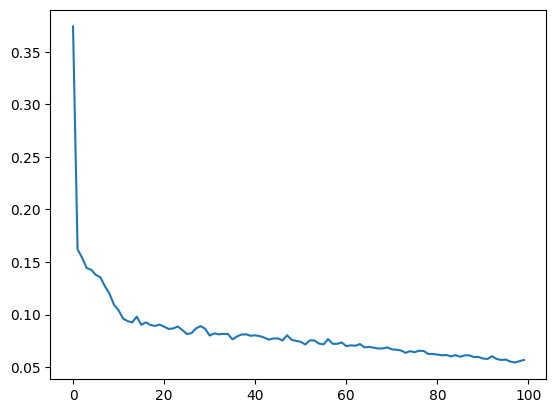

In [32]:
plt.plot(loss)
plt.show()

# Comparing a single image

In [33]:
h = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/high/1.png")
h = h.resize((256, 256))
l = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/low/1.png")
l = l.resize((256,256))
h = input_transform(h)
l = input_transform(l)

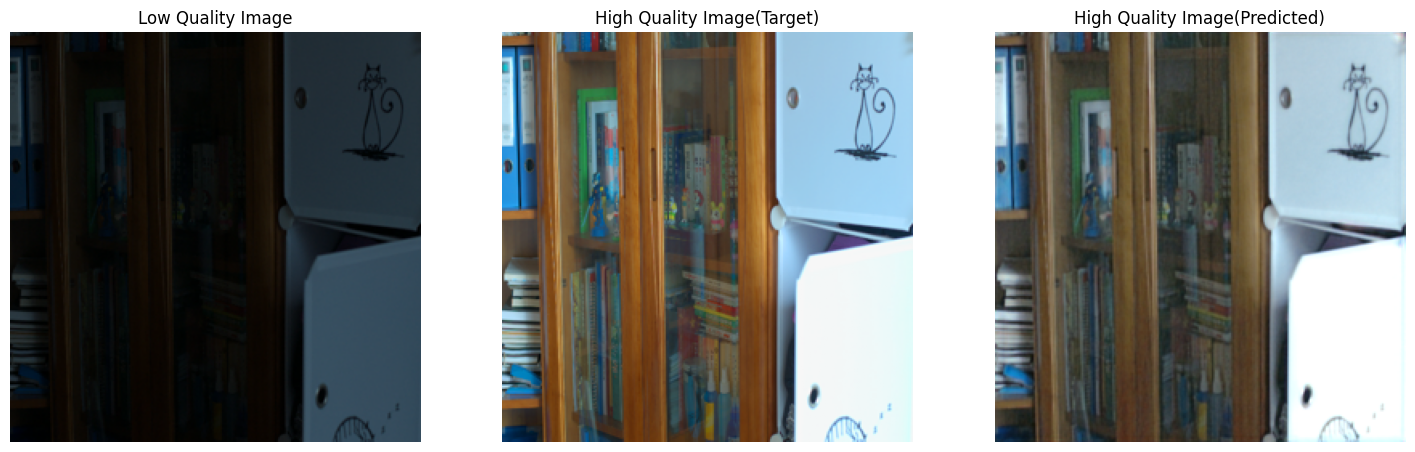

23.848798790130562
-0.06420559036991744


In [34]:
Model.eval()
i = l.unsqueeze(0)
i = i.to(device)
d = Model(i)
d = d.to("cpu")
d = d.squeeze()
d = d.detach().numpy()
d = np.transpose(d,(1,2,0))
l = np.transpose(l.numpy(),(1,2,0))
h = np.transpose(h.numpy(),(1,2,0))
dis_img_test(l*255, h*255, d*255,)
psnr =  calculate_psnr(d, h)
print(psnr)
psnr = calculate_psnr(l, h)
print(psnr)

# Uploading the model to huggingface

In [35]:
model = Model.to("cpu")

In [36]:
token = "hugging_face_token"
HfFolder.save_token(token)

In [37]:
api = HfApi()
repo_id = "vaibhavprajapati22/Image_Denoising_RIDNet"  
api.create_repo(repo_id=repo_id, repo_type="model", token=token, exist_ok=True)

RepoUrl('https://huggingface.co/vaibhavprajapati22/Image_Denoising_RIDNet', endpoint='https://huggingface.co', repo_type='model', repo_id='vaibhavprajapati22/Image_Denoising_RIDNet')

In [38]:
output_dir = "./Image_Denoising_RIDNet"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

In [39]:
config = {
    "architecture": "RIDNet",
    "input_channels": 3,
    "output_channels": 3,
    "num_features": 64,
    "layers": [
        {"type": "Conv2d", "in_channels": 3, "out_channels": 64, "kernel_size": [3, 3], "stride": 1, "padding": 1},
        {"type": "ReLU", "inplace": False},
        
        {"type": "EAM", "in_channels": 64, "out_channels": 64},
        {"type": "EAM", "in_channels": 64, "out_channels": 64},
        {"type": "EAM", "in_channels": 64, "out_channels": 64},
        {"type": "EAM", "in_channels": 64, "out_channels": 64},

        {"type": "Conv2d", "in_channels": 64, "out_channels": 3, "kernel_size": [3, 3], "stride": 1, "padding": 1, "dilation": 1}
    ],
    "skip_connections": [
        {"type": "long", "from": "input", "to": "eam1"},
        {"type": "long", "from": "input", "to": "output"}
    ],
    "initialization": {
        "Conv2d": "xavier_uniform",
        "BatchNorm2d": {
            "weight": 1,
            "bias": 0
        }
    }
}

with open(os.path.join(output_dir, "config.json"), 'w') as f:
    json.dump(config, f)

In [40]:
readme = """
---
language: en
tags:
- image-processing
- image-denoising
- deep-learning
license: apache-2.0
model_name: Image Denoising Model
---

# RIDNet Model 

This Repo contains the weights and config of RIDNet Model that can be used for image denoising.

# Datasets

- LOL Dataset
- Smartphone Image Denoising Dataset

# References
https://arxiv.org/pdf/1904.07396v2.pdf

"""
with open(os.path.join(output_dir, "README.md"), 'w') as f:
    f.write(readme)

In [41]:
api.upload_folder(
    folder_path=output_dir,
    repo_id=repo_id,
    repo_type="model",
    commit_message="Initial commit",
    token=token
)

print(f"Model successfully uploaded to https://huggingface.co/{repo_id}")

pytorch_model.bin:   0%|          | 0.00/24.0M [00:00<?, ?B/s]

Model successfully uploaded to https://huggingface.co/vaibhavprajapati22/Image_Denoising_RIDNet
